### Install the needed libraries

In [6]:
import subprocess
import sys

# List of required packages
required_packages = [
    "pandas", "numpy", "matplotlib", "gym", "gymnasium", "torch", "torchvision", "statsbombpy"
]

def install_package(package):
    """Installs a package using pip if it's not already installed."""
    try:
        __import__(package)
        print(f"{package} is already installed.")
    except ImportError:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# Check and install missing packages
for package in required_packages:
    install_package(package)


pandas is already installed.
numpy is already installed.
matplotlib is already installed.
gym is already installed.
gymnasium is already installed.
torch is already installed.


KeyboardInterrupt: 

### Draw Pitch Function

In [1]:
import matplotlib.pyplot as plt
from matplotlib.patches import Arc

In [2]:
def draw_pitch(ax=None, field_color='green'):
    """
    Draw a 120 x 80 pitch on the given Axes.
    (0,0) is top-left, (120,80) is bottom-right.
    """
    if ax is None:
        ax = plt.subplots(figsize=(12.0, 8.0))
    
    # Set pitch background
    if field_color == 'green':
        ax.set_facecolor('mediumseagreen')
        lc = 'whitesmoke'  # line color
        border_color = 'white'  # Border color to differentiate pitch edges
    else:
        lc = 'black'
        border_color = 'white'
    
    # Outer boundaries with distinct color
    ax.plot([0,0],[0,80], color=border_color, linewidth=3)
    ax.plot([120,120],[0,80], color=border_color, linewidth=3)
    ax.plot([0,120],[0,0], color=border_color, linewidth=3)
    ax.plot([0,120],[80,80], color=border_color, linewidth=3)
    
    # Center line
    ax.plot([60,60],[0,80], color=lc, linewidth=2)
    
    # Center circle
    center_circle = plt.Circle((60, 40), 10, color=lc, fill=False, linewidth=2)
    ax.add_patch(center_circle)
    
    # Penalty areas and arcs (both sides fixed)
    for x in [0, 120]:
        penalty_x = 18 if x == 0 else 120-18
        goal_x = 6 if x == 0 else 120-6
        penalty_spot = 11 if x == 0 else 109
        arc_center = (12, 40) if x == 0 else (108.2, 40)
        arc_angle = 0 if x == 0 else 180
        
        # Penalty area
        ax.plot([x, penalty_x], [18, 18], color=lc, linewidth=2)
        ax.plot([penalty_x, penalty_x], [18, 62], color=lc, linewidth=2)
        ax.plot([x, penalty_x], [62, 62], color=lc, linewidth=2)
        
        # Goal area
        ax.plot([x, goal_x], [30, 30], color=lc, linewidth=2)
        ax.plot([goal_x, goal_x], [30, 50], color=lc, linewidth=2)
        ax.plot([x, goal_x], [50, 50], color=lc, linewidth=2)
        
        # Penalty spots
        ax.plot([penalty_spot], [40], marker='o', markersize=5, color=lc)

        # Center spot
        ax.plot([60], [40], marker='o', markersize=5, color=lc)
        
        # Penalty arcs
        penalty_arc = Arc(
            arc_center, 20, 20, angle=arc_angle, 
            theta1=308, theta2=52, color=lc, linewidth=2
        )
        ax.add_patch(penalty_arc)
        
    # Corners
    corner_radius = 2

    ax.add_patch(plt.Circle((0, 0), corner_radius, color=lc, fill=False, linewidth=2))      # top-left
    ax.add_patch(plt.Circle((120, 0), corner_radius, color=lc, fill=False, linewidth=2))    # top-right
    ax.add_patch(plt.Circle((0, 80), corner_radius, color=lc, fill=False, linewidth=2))     # bottom-left
    ax.add_patch(plt.Circle((120, 80), corner_radius, color=lc, fill=False, linewidth=2))   # bottom-right

    
    # Flip y-axis so top=0
    ax.set_xlim(0,120)
    ax.set_ylim(80,0)
    
    # Remove ticks but maintain pitch edges visibility
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    
    return ax

### Action Analysis from StasBomb360

First we need to discover how many different actions (called "event" in the dataset) we have in the statsbomb dataset, so that we can define the action space in a coherent way (see after)

In [3]:
# Suppress the authentication warning
import warnings
from statsbombpy.api_client import NoAuthWarning
warnings.simplefilter("ignore", NoAuthWarning)

from statsbombpy import sb

# Load a sample match (you can change the match_id based on available data)
match_id = 3795221  # Example match from StatsBomb Open Data

# Get all events from the match
events = sb.events(match_id)

# Extract unique action types (event types)
action_types = events["type"].unique()

i = 0

# Print action names
for action in action_types:
    print(f"{i}) {action}")
    i += 1

0) Starting XI
1) Half Start
2) Pass
3) Ball Receipt*
4) Carry
5) Duel
6) Pressure
7) Dribbled Past
8) Dribble
9) Foul Committed
10) Foul Won
11) Block
12) Clearance
13) Ball Recovery
14) Interception
15) Miscontrol
16) Dispossessed
17) Shot
18) Goal Keeper
19) Own Goal Against
20) Own Goal For
21) Half End
22) Injury Stoppage
23) Referee Ball-Drop
24) Shield
25) Substitution
26) Tactical Shift
27) Player Off


##  Refining the Action Space for Reinforcement Learning

From the list of actions in the StatsBomb dataset, we can categorize them into **offensive** and **defensive** actions. After this, we refine the **action space** of our RL environment by selecting only the actions that are relevant for **decision-making** in offensive/defensive play (goal-scoring strategies).

---

## Relevant Actions for Our RL Agent

### **Offensive** Actions (Useful for Decision-Making)
- **Pass** → Essential for ball distribution and creating chances.
- **Ball Receipt** → Confirms successful passes and transitions.
- **Carry** → Moving with the ball, affecting positioning and space creation.
- **Dribble** → One-on-one skill to beat defenders.
- **Shot** → Attempting to score.
- **Own Goal Against** → Indicates defensive mistakes, but can be useful to penalize bad decisions.

### **Defensive/Pressing** Actions (Useful for Tactical Learning)
- **Duel** → Can indicate a contest for the ball (e.g., aerial duels).
- **Pressure** → Key for counter-pressing and defensive pressure.
- **Dribbled Past** → Helps track defensive performance and weaknesses.
- **Block** → Can be used to evaluate shot-blocking scenarios.
- **Clearance** → Defensive recovery from dangerous situations.
- **Ball Recovery** → Winning back possession, useful for counterattacks.
- **Interception** → Cutting passing lanes, influencing decision-making.

### **Othe** actions
- **GoalKeeper** → Refers to any action performed by the goalkeeper.
- **Substitution** → change a starting players with a benched one.
- **Foul Committed / Foul Won** → Might be useful for penalty simulations

---

### **Actions We Can Ignore**
These actions do not provide direct decision-making value for our RL agent:
- **Starting XI / Half Start / Half End** → Only metadata, no impact on play
- **Referee Ball-Drop / Injury Stoppage** → Unrelated to tactical learning
- **Tactical Shift / Player Off** → Not relevant unless we simulate full matches
- **Miscontrol / Dispossessed** → Useful for analysis, but not direct agent actions
- **Shield** → Shield action refers to when a player uses their body to shield the ball from an opponent. It is rare and mostly defensive
- **Own Goal For** → Since it represents an error for the opposite team, is not usefull at all (It’s not an intentional action like passing or shooting)

---

## Final RL Action Space
Based on the StatsBomb dataset, we define **19 actions** for our RL agent:

| **Action Index** | **StatsBomb Action** | **RL Interpretation** | **Data Source** |
|------------------|---------------------|----------------------|------------------|
| 0  | Pass | Standard pass to a teammate | StatsBomb 360 |
| 1  | Carry | Move forward with the ball | StatsBomb 360 |
| 2  | Dribble | Try to beat a defender one-on-one | StatsBomb 360 |
| 3  | Shot | Attempt to score | StatsBomb 360 |
| 4  | Through Pass | Pass to break defensive lines | StatsBomb 360 |
| 5  | Cross | Deliver the ball into the box | StatsBomb 360 |
| 6  | Pressure | Apply pressure on an opponent | StatsBomb 360 |
| 7  | Tackle (from duel)| Attempt to take the ball from an opponent | StatsBomb 360 |
| 8  | Ball Recovery | Win back possession of a loose ball | StatsBomb 360 |
| 9  | Block | Prevent a shot or pass | StatsBomb 360 |
| 10 | Interception | Cut off an opponent's pass | StatsBomb 360 |
| 11 | Clearance | Remove the ball from danger | StatsBomb 360 |
| 12 | Goalkeeper Action | Save, punch, sweep, or distribute the ball | StatsBomb 360 |
| 13 | Throw-In | Restart play from the sideline | **Simulated** |
| 14 | Goal Kick | Restart play from the goalkeeper | **Simulated** |
| 15 | Corner Kick | Deliver a cross or pass from a corner kick | **Simulated** |
| 16 | Free Kick | Take a direct or indirect free kick | **Simulated** |
| 17 | Foul Committed or Won | Tactical or accidental foul (negative reward) | StatsBomb 360 |
| 18 | Substitution | Change a player (strategic decision) | StatsBomb 360 |

**Note**: For the Through Pass, you can define it as a pass that is played into the space behind the defense to split defenders and create an opportunity for a teammate to run onto the ball. In an RL environment, this action could be implemented so that when selected, it simulates a pass aimed at breaking defensive lines—possibly by updating the state to reflect a significant advancement of the ball toward the opponent’s goal and a change in possession probability favoring a counterattack.


## **How Do We Simulate Set-Pieces?**
Since **throw-ins, goal kicks, corners, and free kicks** are not actions that a player decides freely but occur due to **specific match conditions**, we must **simulate** them by triggering them based on the game state.


| **Action** | **Trigger Condition** | **How We Simulate It?** |
|------------|----------------------|----------------------|
| **Throw-In** | Ball goes out over the **sidelines** | The team that last touched the ball loses possession. The RL agent can select a passing option for the throw-in. |
| **Corner Kick** | Ball goes out over the **goal line**, last touched by a defender | The attacking team gets a corner. The RL agent can decide whether to cross, pass short, or play backward. |
| **Goal Kick** | Ball goes out over the **goal line**, last touched by an attacker | The defending team’s goalkeeper gets the ball and can distribute it via pass or long clearance. |
| **Free Kick** | A foul is committed (depends on position) | The RL agent decides whether to shoot (if close to goal) or pass/cross if farther from goal. |



# Reinforcement Learning Enviroment

In [4]:
import gym
import numpy as np
from gym import spaces

This cell below defines the environment for the Reinforcement Learning (RL) model by creating a FootballEnv class that simulates a football field where players can take actions such as passing, shooting, and dribbling. 
First of all we have an observation space in the enviroment in which are representsed the player positions and the ball movement while in an action space there are included different tactical choices. 
There is an implementation of the reset function: it is useful to initialize the game state. Instead, the step function updates the environment based on the chosen action and provides rewards to guide the learning process.

### Why inheriting?

gym.Env is the base class for all OpenAI Gym environments. By inheriting from it, we automatically gain the structure needed to integrate our environment with RL libraries. 

Key Reasons for Inheriting from gym.Env
	1.	Compatibility → RL algorithms expect environments to follow a standard interface (reset(), step(), etc.).
	2.	Reusability → We don’t need to rewrite the entire RL framework, just customize our football logic.
	3.	Integration → Works seamlessly with RL libraries like Stable-Baselines3, TensorFlow Agents, and PyTorch RL implementations.

Stable-Baselines3 (SB3) is a high-level RL library built on PyTorch that provides optimized implementations of common RL algorithms. It has Pre-implemented algorithms such as PPO, DQN, SAC, A2C, etc., it is easy to train and evaluate thanks to the simple API for training RL agents. 

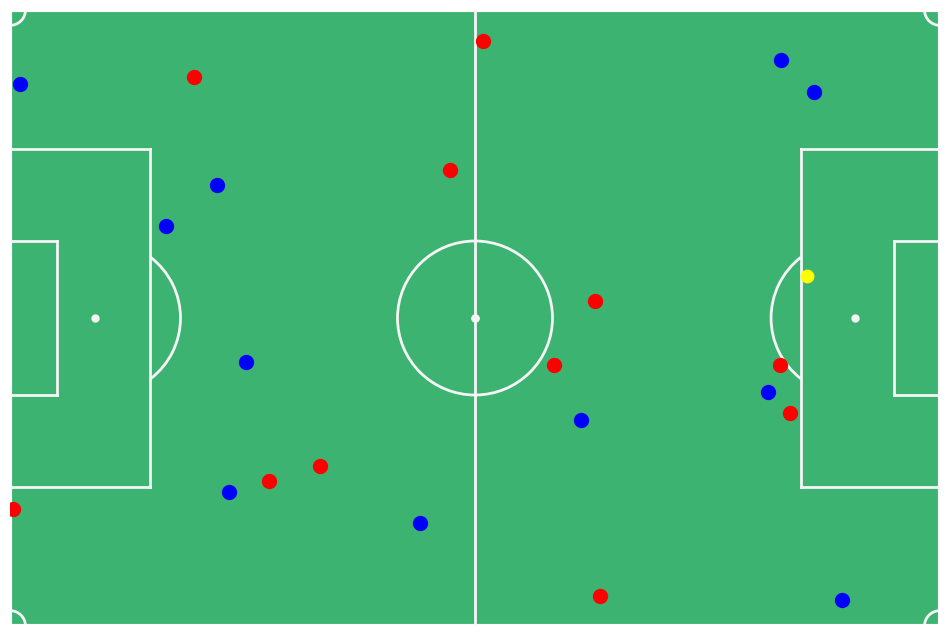

In [5]:
# Load the custom environment
class FootballEnv(gym.Env):
    
    def __init__(self):
        """Initialize the football environment."""
        super(FootballEnv, self).__init__()

        # Observation space: 23 entities (22 players + ball), each with (x, y, vx, vy, team)
        self.observation_space = spaces.Box(low=0, high=120, shape=(23, 5), dtype=np.float32)

        # Action space: 19 discrete football actions
        self.action_space = spaces.Discrete(19)

        # Match parameters
        self.state = None
        self.match_time = 0
        self.halftime_switched = False  
        self.reset()

    def reset(self):
        """Reset the environment at the start of a match or after a goal."""
        self.match_time = 0  
        self.halftime_switched = False  

        # Initialize player positions: Home team (left), Away team (right)
        self.state = np.zeros((23, 5))
        self.state[:, 0] = np.random.uniform(0, 120, size=23)  # X positions
        self.state[:, 1] = np.random.uniform(0, 80, size=23)   # Y positions
        self.state[:, 4] = np.array([0] * 11 + [1] * 11 + [2]) # 0 for home, 1 for away, 2 for ball

        return self.state

    def step(self, action):
        """Execute an action and return the new state, reward, and done flag."""
        reward = 0
        done = False
        self.match_time += 5  # Each step is 5 seconds

        # Random movement update for players and ball
        self.state += np.random.normal(0, 0.5, size=(23, 5))  

        # If match time exceeds 90 minutes, end the game
        if self.match_time >= 90 * 60:
            done = True

        return self.state, reward, done, {}

# Simulate and visualize the first match
def simulate_match():
    env = FootballEnv()
    obs = env.reset()

    fig, ax = plt.subplots(figsize=(12, 8))
    draw_pitch(ax)

    for t in range(200):  # Simulate 200 steps (~16 minutes of play)
        action = env.action_space.sample()  # Random action selection
        obs, reward, done, _ = env.step(action)

        ax.clear()
        draw_pitch(ax)

        # Plot players and ball positions
        home_players = obs[:11]
        away_players = obs[11:22]
        ball = obs[22]

        ax.scatter(home_players[:, 0], home_players[:, 1], c='blue', s=100, label="Home", zorder=3)
        ax.scatter(away_players[:, 0], away_players[:, 1], c='red', s=100, label="Away", zorder=3)
        ax.scatter(ball[0], ball[1], c='yellow', s=80, marker="o", label="Ball", zorder=3)

        plt.pause(0.1)  # Pause to create animation effect

        if done:
            break

    plt.show()

# Run the match simulation
simulate_match()